# Neural Networks Continued

This notebook will attempt to train some Neural Networks on the Training data and save it for later use. It is an extension of 012 as I kept running into problems there

## Author: Alexander Goudemond, Student Number: 219030365

In this notebook, we are going to begin looking at training some neural networks.

I have tried to go through several U-net tutorials - all of which failed. I suspect there is a combination of problems affecting me:

- The tutorial data-sets are not clean or not accessible (hosted on private servers or websites, like Kaggle, Medium, PyImageSearch)

- The implementation is complicated and built on old dependencies

- there is too much data being brought in for training at one time, for offline use

- the offline training I have been trying to do is not possible, as my Graphics Card does not have enough VRAM

To try and overcome these challenges - I am going to load a single folder from our data-set into some training variables, and attempt to train a model on just those. I am unable to do an example tutorial - so I am hoping for the best with my implementation

# Mount Drive

We need to access some images loaded into Google Drive, so here we mount it

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Please ensure the following folders exist

drive > MyDrive > COMP700_Images > COMP700_Training_GT

drive > MyDrive > COMP700_Images > COMP700_Training_ST

drive > MyDrive > COMP700_Neural_Network_Code

The latter location is where the Jupyter Notebooks will be loaded, and the former directories will contain the images used. These images are generated offline by the other notebooks and then uploaded to Google Drive

To try and fix the problems experienced in notebook 012, we will start by loading a larger dataset - all the GT images

# Imports

In [ ]:
from os import getcwd, walk, mkdir, stat, remove
from os import sep # used later on, in a function, to print directory contents
from os.path import exists, basename, join

from shutil import copyfile

from PIL.Image import fromarray
import cv2

import matplotlib.pyplot as plt
import numpy as np

# Load images into variables

Let us now attempt to get all the training data in 1 place

In [ ]:
getcwd()

'/content'

In [ ]:
google_drive_path = "/drive/MyDrive"
training_data_folder = "COMP700_Training_GT"
training_data_directory = getcwd() + google_drive_path + "/COMP700_Images/" + training_data_folder
desired_directory = ""

data_roots = []

maxLength = -1
length = 0

# look for largest length
for root, dirs, files in walk(training_data_directory):
    # print(dirs)
    if ("X" in dirs):
      # print("Yes", root)
      data_roots.append(root)

data_roots


['/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/PhC-C2DH-U373/PhC-C2DH-U373/01',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/PhC-C2DH-U373/PhC-C2DH-U373/02',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-N2DH-GOWT1/Fluo-N2DH-GOWT1/02',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-N2DH-GOWT1/Fluo-N2DH-GOWT1/01',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/DIC-C2DH-HeLa/DIC-C2DH-HeLa/02',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/DIC-C2DH-HeLa/DIC-C2DH-HeLa/01',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-N2DL-HeLa/Fluo-N2DL-HeLa/02',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-N2DL-HeLa/Fluo-N2DL-HeLa/01',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/BF-C2DL-HSC/BF-C2DL-HSC/01',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/BF-C2DL-HSC/BF-C2DL-HSC/02',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-C

Next, we can append an "X" and "Y" tag onto each for the paths to our images

In [ ]:
x_paths = []
y_paths = []

for path in data_roots:
    x_paths.append( path + "/X" )
    y_paths.append( path + "/Y" )

Now, we can use those paths to load the images in each directory into training variables:

In [ ]:
x_image_paths = []

for path in x_paths:
    for root, dirs, files in walk(path):
        # print(files)
        for image in files:
            x_image_paths.append( path + "/" + image )


In [ ]:
y_image_paths = []

for path in y_paths:
    for root, dirs, files in walk(path):
        # print(files)
        for image in files:
            y_image_paths.append( path + "/" + image )


In [ ]:
len(x_image_paths) == len(y_image_paths)

True

Let's confirm that the images correspond:

In [ ]:
def extractRHS(string, symbol):
    index = string.rfind(symbol)
    # print(index)
    return string[ index + 1 : ]
###

extractRHS("219030365@stu.ukzn.zc.za", "@")

'stu.ukzn.zc.za'

In [ ]:
from random import randint

for i in range(5):
    index = randint(0, len(x_image_paths)-1)

    print("Index:", index, ":", extractRHS(x_image_paths[index], "/"), 
          "and", extractRHS(y_image_paths[index], "/") )

Index: 441 : processed1_t0757.tif and man_seg0893.tif
Index: 365 : processed1_t145.tif and man_seg095.tif
Index: 87 : processed1_t061.tif and man_seg007.tif
Index: 549 : processed1_t030.tif and man_seg034.tif
Index: 431 : processed1_t0088.tif and man_seg0007.tif


They dont match! Perhaps Drive uses some kind of hashing function to store their files... Let us sort the lists:

In [ ]:
x_image_paths.sort()
y_image_paths.sort()

In [ ]:
from random import randint

for i in range(5):
    index = randint(0, len(x_image_paths)-1)

    print("Index:", index, ":", extractRHS(x_image_paths[index], "/"), 
          "and", extractRHS(y_image_paths[index], "/") )

Index: 95 : processed1_t1137.tif and man_seg1137.tif
Index: 541 : processed1_t005.tif and man_seg005.tif
Index: 190 : processed1_t009.tif and man_seg009.tif
Index: 427 : processed1_t073.tif and man_seg073.tif
Index: 4 : processed1_t0183.tif and man_seg0183.tif


Now, next step is to load each image into an array:

In [ ]:
x_images = []
length = len(x_image_paths)
count = 0
dim = (128, 128)

for item in x_image_paths:
    img = np.array( cv2.imread(item) )
    resized_img = cv2.resize(img, dim)
    x_images.append( resized_img )

    count += 1
    if (count % 50 == 0) and (count != 0):
        print(count, "images processed out of", length)

50 images processed out of 578
100 images processed out of 578
150 images processed out of 578
200 images processed out of 578
250 images processed out of 578
300 images processed out of 578
350 images processed out of 578
400 images processed out of 578
450 images processed out of 578
500 images processed out of 578
550 images processed out of 578


In [ ]:
y_images = []
length = len(y_image_paths)
count = 0
dim = (128, 128)

for item in y_image_paths:
    # Read as gray for NN
    img = np.array( cv2.imread(item, cv2.IMREAD_GRAYSCALE) )
    resized_img = cv2.resize(img, dim)
    y_images.append( resized_img )

    count += 1
    if (count % 50 == 0) and (count != 0):
        print(count, "images processed out of", length)

50 images processed out of 578
100 images processed out of 578
150 images processed out of 578
200 images processed out of 578
250 images processed out of 578
300 images processed out of 578
350 images processed out of 578
400 images processed out of 578
450 images processed out of 578
500 images processed out of 578
550 images processed out of 578


In [ ]:
len(x_images) == len(y_images)

True

Now that our information corresponds, let us shuffle and split the data:

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_images, y_images, test_size=0.2, random_state=4) # shuffles and partitions data

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

Shape: (128, 128, 3)
Shape: (128, 128, 3)
Shape: (128, 128, 3)


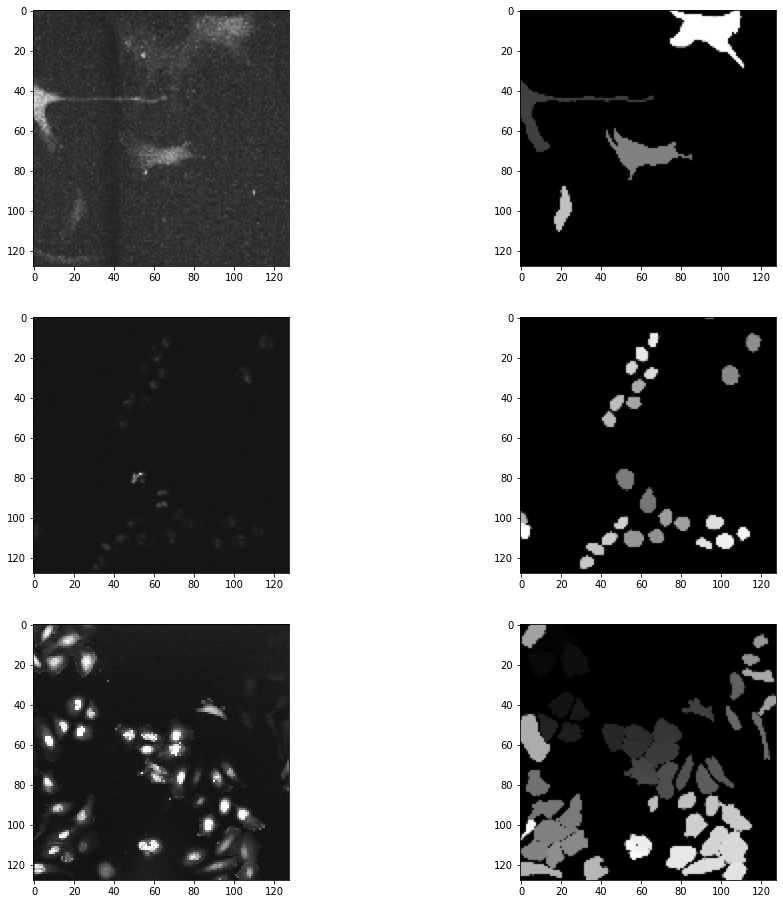

In [ ]:
# Let's now try show these images side by side to verify results:

from random import randint

fig = plt.figure(figsize=(16, 16))

for i in range(0, 3):
    index = randint(0, len(x_train) - 1)
    print("Shape:", x_train[index].shape)

    plt.subplot(3, 2, i * 2 + 1)
    plt.imshow(x_train[index])

    plt.subplot(3, 2, i * 2 + 2)
    plt.imshow(y_train[index], cmap="gray")

plt.show()

Okay, we can now try an look at that neural network again and re-examine our problems:

# Unet

We know from 012 that the  RMSprop compiler worked well, so we will begin with that!

First - we try run it on a larger data-set with shuffled data

In [ ]:
import tensorflow as tf
from tensorflow import keras

from keras.layers import Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate, Input, Lambda

In [ ]:
# original author: "Sreenivas Bhattiprolu"
# Github directory: "Python for Microscopists"
# URL: https://github.com/bnsreenu/python_for_microscopists
def get_unet(img_width, img_height, input_channels, output_channels):
    #Build the model
    inputs = Input((img_width, img_height, input_channels))
    s = Lambda(lambda x: x / 255)(inputs)

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    
    outputs = Conv2D(output_channels, (1, 1), activation='sigmoid')(c9) # output_channels will be updated to 1 here...

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

    return model
###

In [ ]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_INPUT = 3
IMG_OUTPUT = 1

unet_model_rmsprop = get_unet(IMG_WIDTH, IMG_HEIGHT, IMG_INPUT, IMG_OUTPUT)

unet_model_rmsprop.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
unet_model_rmsprop.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_1 (Lambda)              (None, 128, 128, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 16  448         ['lambda_1[0][0]']               
                                )                                                                 
                                                                                            

In [ ]:
ACCURACY_THRESHOLD = 0.75

class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if(logs.get('accuracy') > ACCURACY_THRESHOLD):
			print("\nReached %2.2f%% loss, so stopping training!!" %(ACCURACY_THRESHOLD*100))
			self.model.stop_training = True

# Instantiate a callback object
CALLBACKS = myCallback()

In [ ]:
# change epochs size

VALIDATION_SPLIT = 0.1
BATCH_SIZE = 16
EPOCHS=600

unet_model_rmsprop_history = unet_model_rmsprop.fit(
                                                    x=x_train, 
                                                    y=y_train, 
                                                    validation_split=VALIDATION_SPLIT, 
                                                    batch_size=BATCH_SIZE, 
                                                    epochs=EPOCHS, 
                                                    callbacks=CALLBACKS
                                                    )

Epoch 1/600
 6/26 [=====>........................] - ETA: 1s - loss: -86.2646 - accuracy: 0.1182

26/26 [==============================] - 5s 98ms/step - loss: -123.1015 - accuracy: 0.0310 - val_loss: -135.0541 - val_accuracy: 0.0044
Epoch 2/600
26/26 [==============================] - 1s 41ms/step - loss: -134.1277 - accuracy: 0.0046 - val_loss: -135.0508 - val_accuracy: 0.0043
Epoch 3/600
26/26 [==============================] - 1s 41ms/step - loss: -134.1291 - accuracy: 0.0045 - val_loss: -135.0507 - val_accuracy: 0.0043
Epoch 4/600
26/26 [==============================] - 1s 41ms/step - loss: -134.0208 - accuracy: 0.0045 - val_loss: -135.0504 - val_accuracy: 0.0043
Epoch 5/600
26/26 [==============================] - 1s 42ms/step - loss: -134.1368 - accuracy: 0.0045 - val_loss: -135.0504 - val_accuracy: 0.0043
Epoch 6/600
26/26 [==============================] - 1s 41ms/step - loss: -134.1367 - accuracy: 0.0045 - val_loss: -135.0504 - val_accuracy: 0.0043
Epoch 7/600
26/26 [==============================] - 1s 41ms/step - loss: -134.1369 - accuracy: 0.0045 - val_loss: -135.0514

In [ ]:
training_predictions = unet_model_rmsprop.predict(x_train, verbose=1)

15/15 [==============================] - 2s 46ms/step


In [ ]:
preds_train_t = (training_predictions > 0.5).astype(np.uint8)

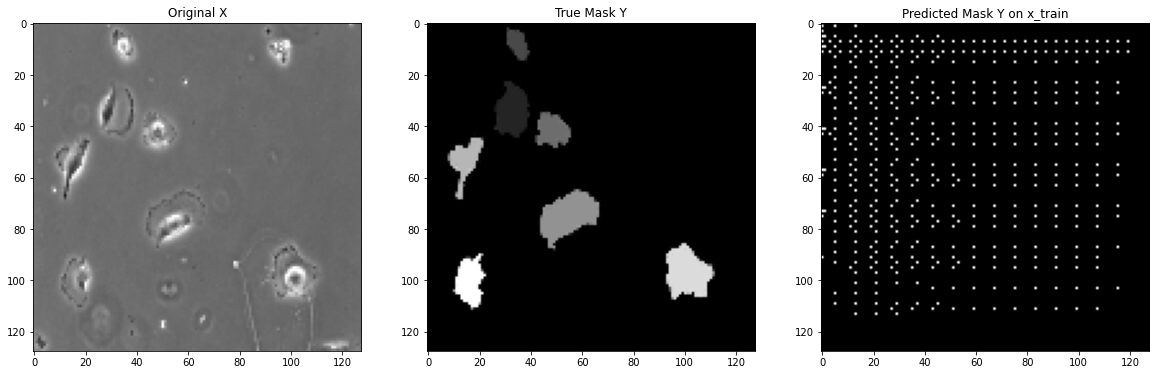

In [ ]:
# Try plot

index = randint(0, len(x_train)-1)

fig = plt.figure(figsize=(20,20))

plt.subplot(1, 3, 1)
plt.title("Original X")
plt.imshow( x_train[index] )

plt.subplot(1, 3, 2)
plt.title("True Mask Y")
plt.imshow( y_train[index], cmap="gray" )

plt.subplot(1, 3, 3)
plt.title("Predicted Mask Y on x_train")
plt.imshow( np.squeeze(preds_train_t[index]), cmap="gray" )

plt.show()


We are getting a similar result as the other notebook. So let us try the other training techniques, and if those fail we can try load an example network and use it

# Unet with 95% accuracy

In [ ]:
ACCURACY_THRESHOLD = 0.90

class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if(logs.get('accuracy') > ACCURACY_THRESHOLD):
			print("\nReached %2.2f%% loss, so stopping training!!" %(ACCURACY_THRESHOLD*100))
			self.model.stop_training = True

# Instantiate a callback object
CALLBACKS = myCallback()

In [ ]:
unet_model_rmsprop_2 = get_unet(IMG_WIDTH, IMG_HEIGHT, IMG_INPUT, IMG_OUTPUT)

unet_model_rmsprop_2.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# change epochs size

VALIDATION_SPLIT = 0.1
BATCH_SIZE = 16
EPOCHS=600

unet_model_rmsprop_2_history = unet_model_rmsprop_2.fit(
                                                    x=x_train, 
                                                    y=y_train, 
                                                    validation_split=VALIDATION_SPLIT, 
                                                    batch_size=BATCH_SIZE, 
                                                    epochs=EPOCHS, 
                                                    callbacks=CALLBACKS
                                                    )

Epoch 1/600
 5/26 [====>.........................] - ETA: 1s - loss: -59.6272 - accuracy: 0.3449

26/26 [==============================] - 4s 59ms/step - loss: -118.3003 - accuracy: 0.0704 - val_loss: -135.0510 - val_accuracy: 0.0043
Epoch 2/600
26/26 [==============================] - 1s 42ms/step - loss: -134.1214 - accuracy: 0.0046 - val_loss: -135.0522 - val_accuracy: 0.0043
Epoch 3/600
26/26 [==============================] - 1s 42ms/step - loss: -134.1340 - accuracy: 0.0045 - val_loss: -135.0504 - val_accuracy: 0.0043
Epoch 4/600
26/26 [==============================] - 1s 42ms/step - loss: -134.0414 - accuracy: 0.0053 - val_loss: -134.8266 - val_accuracy: 0.0064
Epoch 5/600
26/26 [==============================] - 1s 43ms/step - loss: -132.4877 - accuracy: 0.0113 - val_loss: -134.6033 - val_accuracy: 0.0080
Epoch 6/600
26/26 [==============================] - 1s 42ms/step - loss: -132.3495 - accuracy: 0.0139 - val_loss: -134.2792 - val_accuracy: 0.0105
Epoch 7/600
26/26 [==============================] - 1s 42ms/step - loss: -132.5166 - accuracy: 0.0150 - val_loss: -134.1040

In [ ]:
training_predictions = unet_model_rmsprop.predict(x_train, verbose=1)

preds_train_t = (training_predictions > 0.5).astype(np.uint8)

15/15 [==============================] - 0s 24ms/step


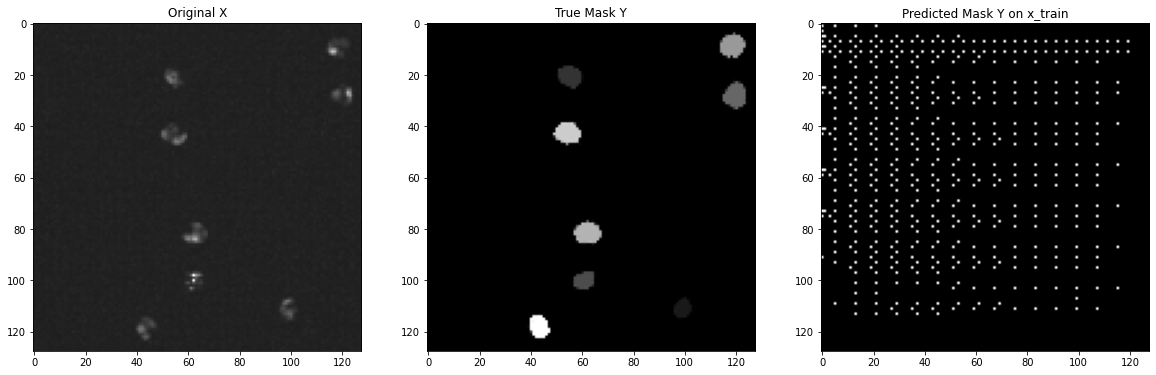

In [ ]:
# Try plot

index = randint(0, len(x_train)-1)

fig = plt.figure(figsize=(20,20))

plt.subplot(1, 3, 1)
plt.title("Original X")
plt.imshow( x_train[index] )

plt.subplot(1, 3, 2)
plt.title("True Mask Y")
plt.imshow( y_train[index], cmap="gray" )

plt.subplot(1, 3, 3)
plt.title("Predicted Mask Y on x_train")
plt.imshow( np.squeeze(preds_train_t[index]), cmap="gray" )

plt.show()


# Custom UNET with other DataSets

Because I am struggling to get the UNET model to predict anything, let us try use a different dataset form a tutorial and see if the model allows that to predict. If so, it may suggest I need to modify my images somehow...

This code is extracted frnom the Tensorflow tutorial on UNet

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-ojp_3x35
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-ojp_3x35


In [ ]:
import tensorflow as tf

import tensorflow_datasets as tfds

In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt


## Download the Oxford-IIIT Pets dataset

The dataset is available from TensorFlow Datasets. The segmentation masks are included in version 3+.

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteD4Z03S/oxford_iiit_pet-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteD4Z03S/oxford_iiit_pet-test.tfrecord*...:   0%…

Dataset oxford_iiit_pet downloaded and prepared to ~/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In addition, the image color values are normalized to the [0, 1] range. Finally, as mentioned above the pixels in the segmentation mask are labeled either {1, 2, 3}. For the sake of convenience, subtract 1 from the segmentation mask, resulting in labels that are : {0, 1, 2}.

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask


In [ ]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask


The dataset already contains the required training and test splits, so continue to use the same splits:

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 8
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE


In [ ]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)


Build the input pipeline, applying the augmentation after batching the inputs:

In [ ]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels


In [ ]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)


In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()


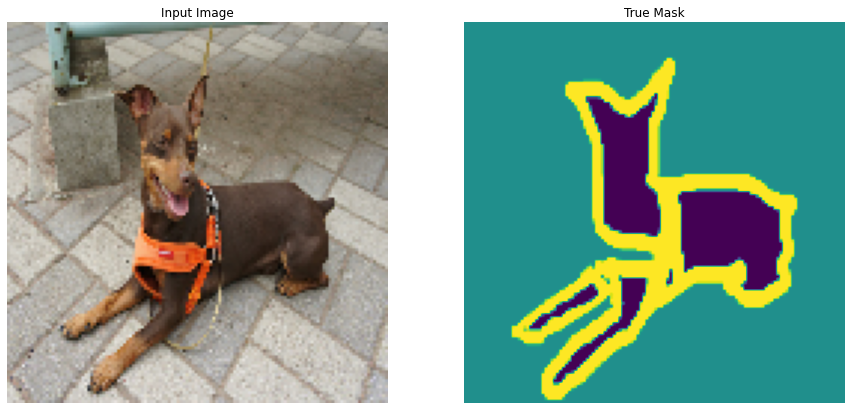

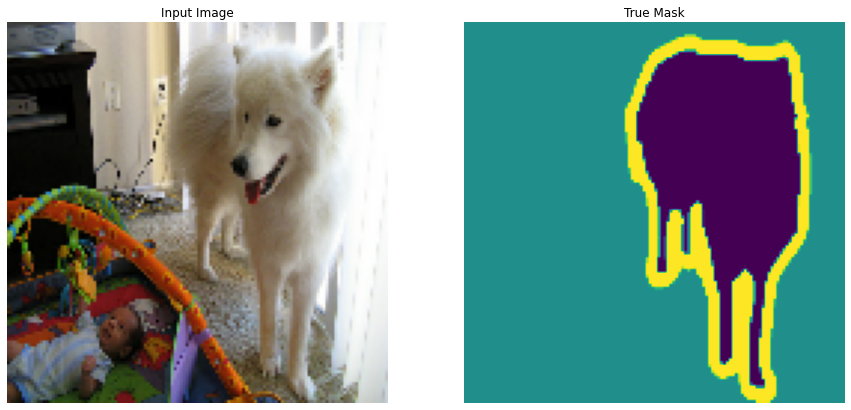

In [ ]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])


## Custom UNET


Let us now use those images in our custom model:

In [ ]:
import tensorflow as tf
from tensorflow import keras

from keras.layers import Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate, Input, Lambda

In [ ]:
# original author: "Sreenivas Bhattiprolu"
# Github directory: "Python for Microscopists"
# URL: https://github.com/bnsreenu/python_for_microscopists
def get_unet(img_width, img_height, input_channels, output_channels):
    #Build the model
    inputs = Input((img_width, img_height, input_channels))
    s = Lambda(lambda x: x / 255)(inputs)

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    
    outputs = Conv2D(output_channels, (1, 1), activation='sigmoid')(c9) # output_channels will be updated to 1 here...

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

    return model
###

In [ ]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_INPUT = 3
IMG_OUTPUT = 1

unet_model_rmsprop = get_unet(IMG_WIDTH, IMG_HEIGHT, IMG_INPUT, IMG_OUTPUT)

unet_model_rmsprop.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
unet_model_rmsprop.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

See what the model predicts without training:

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]


In [ ]:
def show_predictions(model, dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])


1/1 [==============================] - 8s 8s/step


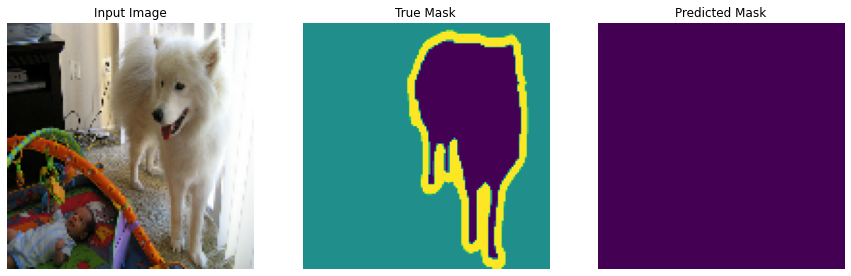

In [ ]:
show_predictions(unet_model_rmsprop)


That makes sense. Now, let us try train it

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))


1/1 [==============================] - 0s 33ms/step


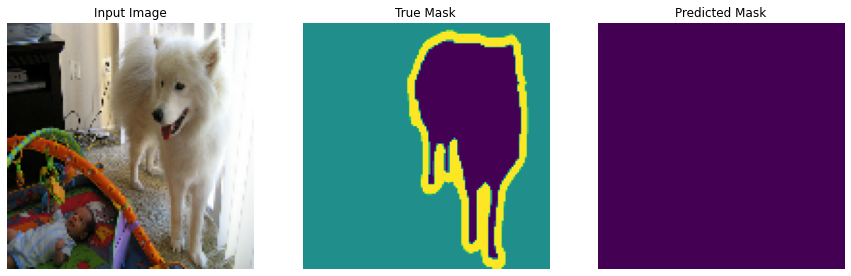


Sample Prediction after epoch 20

460/460 [==============================] - 16s 35ms/step - loss: -212840658821484925419520.0000 - accuracy: 0.4529 - val_loss: -295045060978262193209344.0000 - val_accuracy: 0.4427


In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = unet_model_rmsprop.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])


That did not work! So perhaps our model is poorly defined. Let us now retry with the loaded model from Tensorflow, to compare information

# Define Tensorflow UNet Model

The model being used here is a modified U-Net. A U-Net consists of an encoder (downsampler) and decoder (upsampler). To learn robust features and reduce the number of trainable parameters, use a pretrained model—MobileNetV2—as the encoder. For the decoder, you will use the upsample block, which is already implemented in the pix2pix example in the TensorFlow Examples repo. (Check out the pix2pix: Image-to-image translation with a conditional GAN tutorial in a notebook.)

As mentioned, the encoder is a pretrained MobileNetV2 model. You will use the model from tf.keras.applications. The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False


9406464/9406464 [==============================] - 0s 0us/step


The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples:

In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]


In [ ]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


Note that the number of filters on the last layer is set to the number of output_channels. This will be one output channel per class.

## Train the model

Now, all that is left to do is to compile and train the model.

Since this is a multiclass classification problem, use the tf.keras.losses.CategoricalCrossentropy loss function with the from_logits argument set to True, since the labels are scalar integers instead of vectors of scores for each pixel of every class.

When running inference, the label assigned to the pixel is the channel with the highest value. This is what the create_mask function is doing.

In [ ]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


Plot the resulting model architecture:

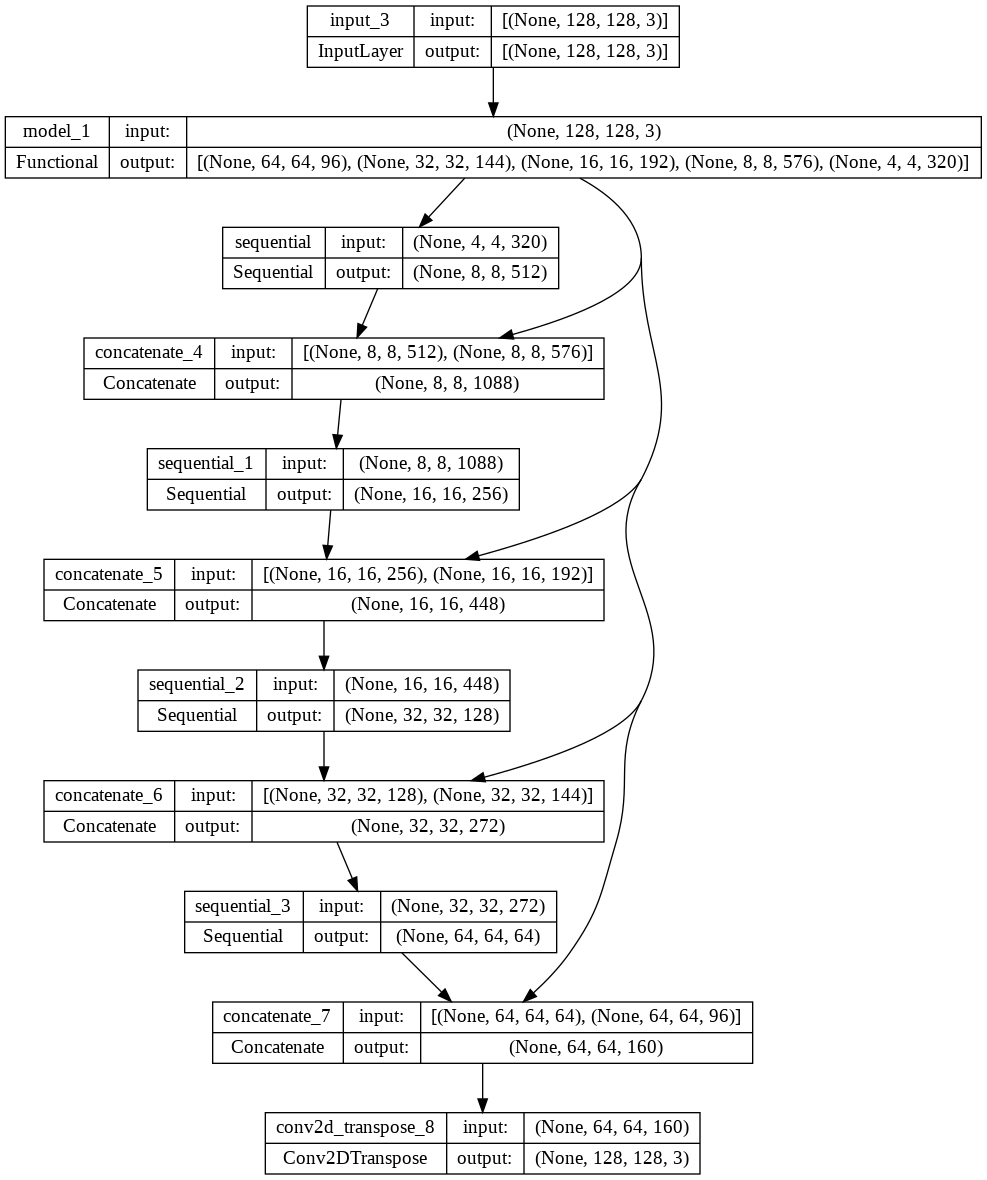

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)


Try out the model to check what it predicts before training:

1/1 [==============================] - 1s 1s/step


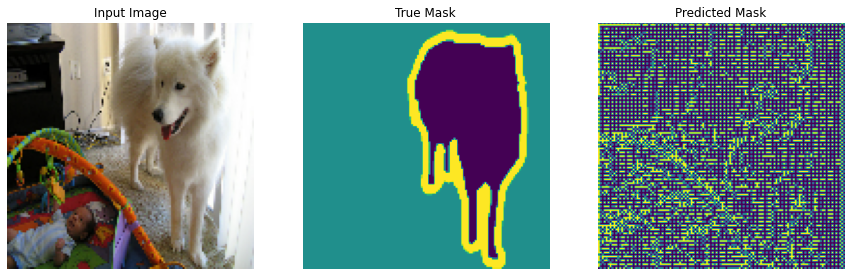

In [ ]:
show_predictions(model)


In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions(model)
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))


1/1 [==============================] - 0s 24ms/step


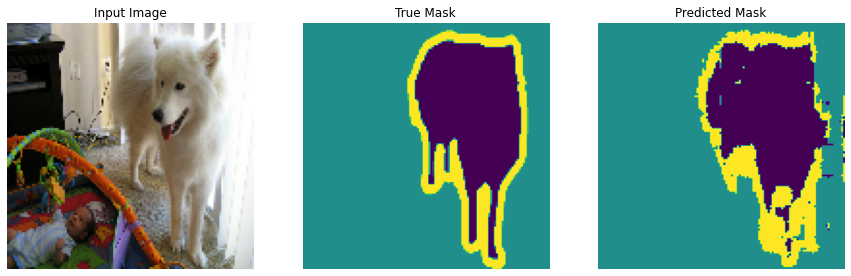


Sample Prediction after epoch 20

460/460 [==============================] - 18s 38ms/step - loss: 0.1648 - accuracy: 0.9258 - val_loss: 0.2769 - val_accuracy: 0.8960


In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])


That is much better! So our model may be poorly defined. Let us next try and use the Tensorflow UNET to predict on our Cell Images

# Use Tensorflow Model to predict Cell Images

We need to access some images loaded into Google Drive, so here we mount it

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Please ensure the following folders exist

drive > MyDrive > COMP700_Images > COMP700_Training_GT

drive > MyDrive > COMP700_Images > COMP700_Training_ST

drive > MyDrive > COMP700_Neural_Network_Code

The latter location is where the Jupyter Notebooks will be loaded, and the former directories will contain the images used. These images are generated offline by the other notebooks and then uploaded to Google Drive

To try and fix the problems experienced in notebook 012, we will start by loading a larger dataset - all the GT images

## Imports

In [ ]:
from os import getcwd, walk, mkdir, stat, remove
from os import sep # used later on, in a function, to print directory contents
from os.path import exists, basename, join

from shutil import copyfile

from PIL.Image import fromarray
import cv2

import matplotlib.pyplot as plt
import numpy as np

## Load images into variables

Let us now attempt to get all the training data in 1 place

In [ ]:
getcwd()

'/content'

In [ ]:
google_drive_path = "/drive/MyDrive"
training_data_folder = "COMP700_Training_GT"
training_data_directory = getcwd() + google_drive_path + "/COMP700_Images/" + training_data_folder
desired_directory = ""

data_roots = []

maxLength = -1
length = 0

# look for largest length
for root, dirs, files in walk(training_data_directory):
    # print(dirs)
    if ("X" in dirs):
      # print("Yes", root)
      data_roots.append(root)

data_roots


['/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/PhC-C2DH-U373/PhC-C2DH-U373/01',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/PhC-C2DH-U373/PhC-C2DH-U373/02',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-N2DH-GOWT1/Fluo-N2DH-GOWT1/02',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-N2DH-GOWT1/Fluo-N2DH-GOWT1/01',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/DIC-C2DH-HeLa/DIC-C2DH-HeLa/02',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/DIC-C2DH-HeLa/DIC-C2DH-HeLa/01',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-N2DL-HeLa/Fluo-N2DL-HeLa/02',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-N2DL-HeLa/Fluo-N2DL-HeLa/01',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/BF-C2DL-HSC/BF-C2DL-HSC/01',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/BF-C2DL-HSC/BF-C2DL-HSC/02',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-C

Next, we can append an "X" and "Y" tag onto each for the paths to our images

In [ ]:
x_paths = []
y_paths = []

for path in data_roots:
    x_paths.append( path + "/X" )
    y_paths.append( path + "/Y" )

Now, we can use those paths to load the images in each directory into training variables:

In [ ]:
x_image_paths = []

for path in x_paths:
    for root, dirs, files in walk(path):
        # print(files)
        for image in files:
            x_image_paths.append( path + "/" + image )


In [ ]:
y_image_paths = []

for path in y_paths:
    for root, dirs, files in walk(path):
        # print(files)
        for image in files:
            y_image_paths.append( path + "/" + image )


In [ ]:
len(x_image_paths) == len(y_image_paths)

True

Let's confirm that the images correspond:

In [ ]:
def extractRHS(string, symbol):
    index = string.rfind(symbol)
    # print(index)
    return string[ index + 1 : ]
###

extractRHS("219030365@stu.ukzn.zc.za", "@")

'stu.ukzn.zc.za'

In [ ]:
from random import randint

for i in range(5):
    index = randint(0, len(x_image_paths)-1)

    print("Index:", index, ":", extractRHS(x_image_paths[index], "/"), 
          "and", extractRHS(y_image_paths[index], "/") )

Index: 559 : processed1_t035.tif and man_seg013.tif
Index: 483 : processed1_t0459.tif and man_seg1196.tif
Index: 287 : processed1_t008.tif and man_seg020.tif
Index: 124 : processed1_t080.tif and man_seg038.tif
Index: 323 : processed1_t062.tif and man_seg113.tif


They dont match! Perhaps Drive uses some kind of hashing function to store their files... Let us sort the lists:

In [ ]:
x_image_paths.sort()
y_image_paths.sort()

In [ ]:
from random import randint

for i in range(5):
    index = randint(0, len(x_image_paths)-1)

    print("Index:", index, ":", extractRHS(x_image_paths[index], "/"), 
          "and", extractRHS(y_image_paths[index], "/") )

Index: 115 : processed1_t0260.tif and man_seg0260.tif
Index: 358 : processed1_t004.tif and man_seg004.tif
Index: 267 : processed1_t046.tif and man_seg046.tif
Index: 262 : processed1_t039.tif and man_seg039.tif
Index: 153 : processed1_t1278.tif and man_seg1278.tif


Now, next step is to load each image into an array:

In [ ]:
x_images = []
length = len(x_image_paths)
count = 0
dim = (128, 128)

for item in x_image_paths:
    img = np.array( cv2.imread(item) )
    resized_img = cv2.resize(img, dim)
    x_images.append( resized_img )

    count += 1
    if (count % 50 == 0) and (count != 0):
        print(count, "images processed out of", length)

50 images processed out of 578
100 images processed out of 578
150 images processed out of 578
200 images processed out of 578
250 images processed out of 578
300 images processed out of 578
350 images processed out of 578
400 images processed out of 578
450 images processed out of 578
500 images processed out of 578
550 images processed out of 578


In [ ]:
y_images = []
length = len(y_image_paths)
count = 0
dim = (128, 128)

for item in y_image_paths:
    # grayscale
    # img = np.array( cv2.imread(item, cv2.IMREAD_GRAYSCALE) ) 
    # try with colour image here
    img = np.array( cv2.imread(item) ) 
    resized_img = cv2.resize(img, dim)
    y_images.append( resized_img )

    count += 1
    if (count % 50 == 0) and (count != 0):
        print(count, "images processed out of", length)

50 images processed out of 578
100 images processed out of 578
150 images processed out of 578
200 images processed out of 578
250 images processed out of 578
300 images processed out of 578
350 images processed out of 578
400 images processed out of 578
450 images processed out of 578
500 images processed out of 578
550 images processed out of 578


In [ ]:
len(x_images) == len(y_images)

True

Now that our information corresponds, let us shuffle and split the data:

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_images, y_images, test_size=0.2, random_state=4) # shuffles and partitions data

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

Shape x: (128, 128, 3) Shape y: (128, 128, 3)
Shape x: (128, 128, 3) Shape y: (128, 128, 3)
Shape x: (128, 128, 3) Shape y: (128, 128, 3)


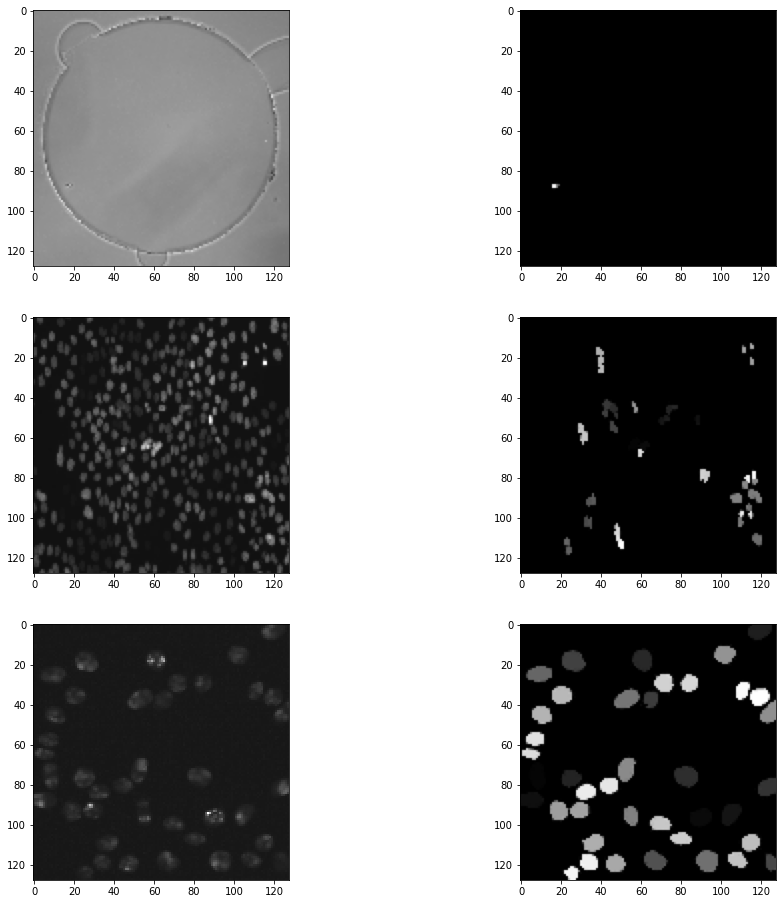

In [ ]:
# Let's now try show these images side by side to verify results:

from random import randint

fig = plt.figure(figsize=(16, 16))

for i in range(0, 3):
    index = randint(0, len(x_train) - 1)
    print("Shape x:", x_train[index].shape, "Shape y:", y_train[index].shape)

    plt.subplot(3, 2, i * 2 + 1)
    plt.imshow(x_train[index])

    plt.subplot(3, 2, i * 2 + 2)
    plt.imshow(y_train[index], cmap="gray")

plt.show()

Now that we have our data, we can use the tensorflow model:

In [ ]:
OUTPUT_CLASSES = 3 # notice output classes

tensorflow_model = unet_model(output_channels=OUTPUT_CLASSES)
# tensorflow_model.compile(optimizer='adam',
#                         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#                         metrics=['accuracy'])
tensorflow_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


Plot the resulting model architecture:

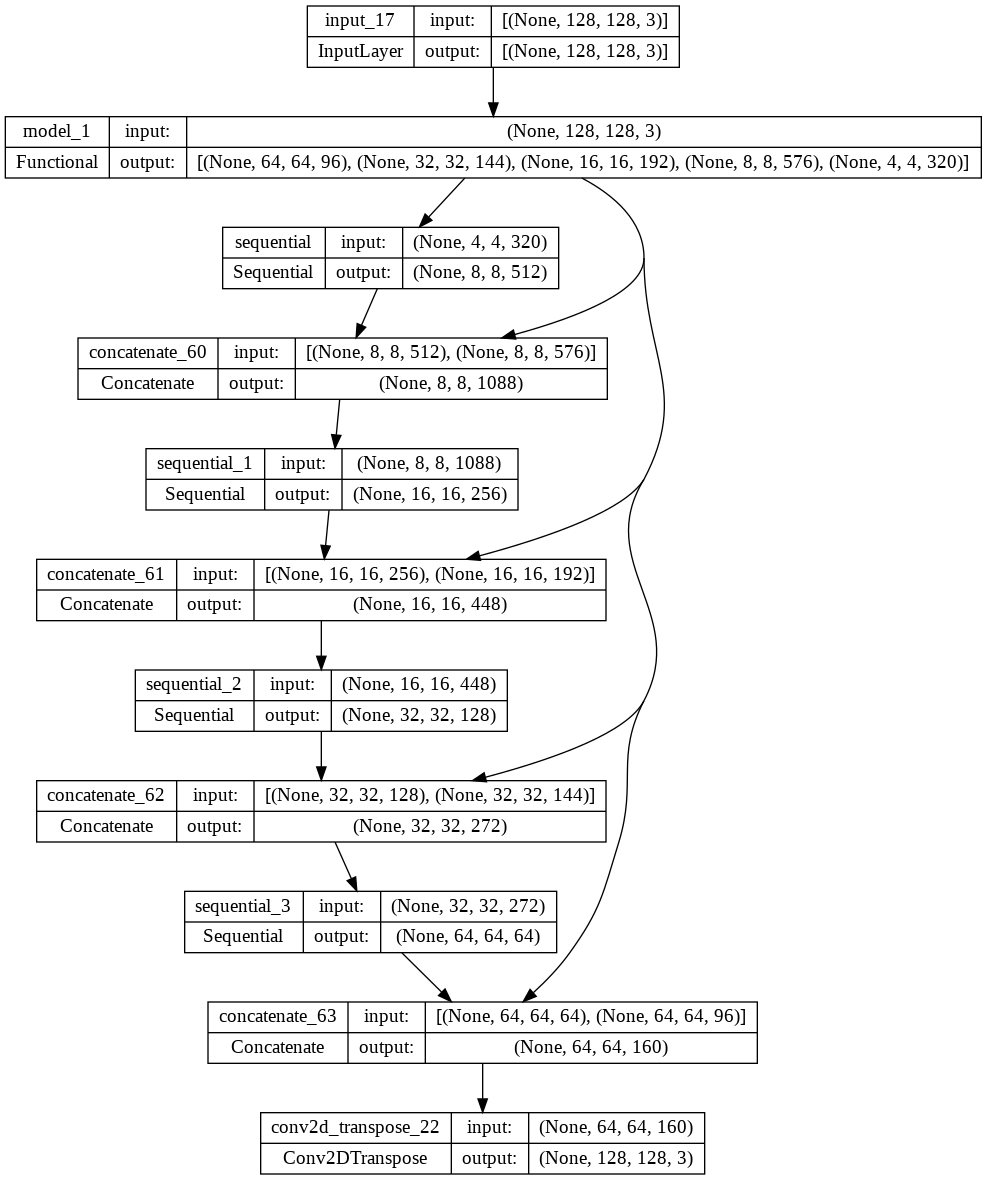

In [ ]:
tf.keras.utils.plot_model(tensorflow_model, show_shapes=True)


Try out the model to check what it predicts before training:

In [ ]:
print(x_train.shape) 
print(y_train.shape) 

print(x_test.shape) 
print(y_test.shape) 

(462, 128, 128, 3)
(462, 128, 128, 3)
(116, 128, 128, 3)
(116, 128, 128, 3)


In [ ]:
sample_image, sample_mask = x_train[0], y_train[0]

In [ ]:
def show_predictions_2(model, dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(tensorflow_model.predict(sample_image[tf.newaxis, ...]))])


1/1 [==============================] - 1s 835ms/step


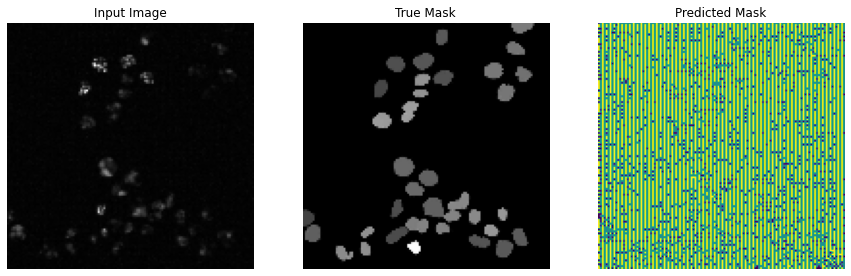

In [ ]:
show_predictions_2(tensorflow_model)


So far so good...

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions(tensorflow_model)
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))


1/1 [==============================] - 0s 20ms/step


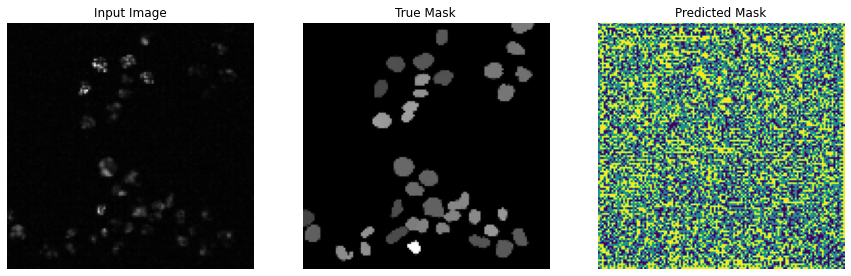


Sample Prediction after epoch 19

57/57 [==============================] - 1s 14ms/step - loss: 32.8470 - accuracy: 0.3404 - val_loss: 32.4686 - val_accuracy: 0.3320


In [ ]:
TRAIN_LENGTH = len(x_train)
BATCH_SIZE = 8
VAL_SUBSPLITS = 5

EPOCHS = 20
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = STEPS_PER_EPOCH//VAL_SUBSPLITS

tensorflow_model_history = tensorflow_model.fit(
                                                x_train,
                                                y_train, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                callbacks=[DisplayCallback()],
                                                validation_steps=VALIDATION_STEPS,
                                                validation_data=(x_test, y_test)
                                                )


## SRMprop optimizer

In [ ]:
def show_predictions_generic(model, dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display_gray([sample_image, sample_mask,
             create_mask(tensorflow_model.predict(sample_image[tf.newaxis, ...]))])


In [ ]:
class DisplayCallbackGeneric(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions_generic(temp_model)
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

    old_lr = self.model.optimizer.lr.read_value()

    # if (old_lr == 0.001):
    # print("Old Learning rate:", old_lr, end=" ")
    new_lr = old_lr * 0.99
    # print("New Learning rate:", new_lr)
    print("\nEpoch: {}. Reducing Learning Rate from {} to {}".format(epoch, old_lr, new_lr))
    self.model.optimizer.lr.assign(new_lr)


In [ ]:
def display_gray(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]), cmap="gray")
    plt.axis('off')
  plt.show()


Compilation Loss of categorical_crossentropy seems to make little difference

- Validation Steps = Steps per Epoch reaches accuracy of approximately 30%

- The learning rate for this model is 0.001. Let us try modifying it via a callback. Reducing the learning to 0.0001 made no difference. Reducing it by 0.99 each run is also not making a difference

- Modifying the batch size and the epochs does not improve things either

1/1 [==============================] - 0s 20ms/step


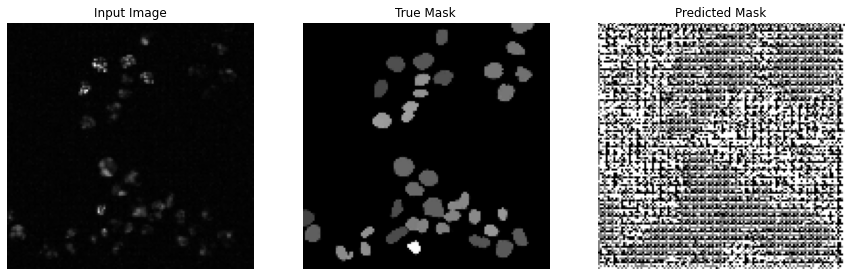


Sample Prediction after epoch 100


Epoch: 99. Reducing Learning Rate from 0.0003697299980558455 to 0.00036603270564228296
231/231 [==============================] - 4s 15ms/step - loss: 32.3072 - accuracy: 0.3377


In [ ]:
OUTPUT_CLASSES = 3 # notice output classes
tensorflow_model_2 = unet_model(output_channels=OUTPUT_CLASSES)

# RMSprop compiler
tensorflow_model_2.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Training Below

TRAIN_LENGTH = len(x_train)
BATCH_SIZE = 2
VAL_SUBSPLITS = 5

EPOCHS = 100
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = STEPS_PER_EPOCH #// VAL_SUBSPLITS

# used in DisplayCallbackGeneric
temp_model = tensorflow_model_2
tensorflow_model_2_history = tensorflow_model_2.fit(
                                                    x_train,
                                                    y_train, 
                                                    epochs=EPOCHS,
                                                    steps_per_epoch=STEPS_PER_EPOCH,
                                                    callbacks=[DisplayCallbackGeneric()],
                                                    validation_steps=VALIDATION_STEPS,
                                                    validation_data=(x_test, y_test)
                                                    )




None of the manipulations seem to be working. Perhaps the masks have different intesity values? Should we try and place them into classes?

In [ ]:
for i in range(5):
    print(np.unique(y_train[i]))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  23  24  25  27  28  29  31  32  34  35  36  37  38  39  40
  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 158 159 160 161 163 165 166 179 232
 237 238 242 245 248 251 252 253 254 255]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  25  29  30  32  33  34  35  37  38  40  42  45  46
  48  49  50  52  53  55  57  58  59  60  62  63  64  67  70  71  72  74
  79  81  84  85  86  88  89  91  92  93  94  95  98 100 101 102 105 106
 108 109 

If we pay attention to the final value in the end of each row, we can see that each image has a different quantity of unique elements. And the masks were provided like that...

The last thing for me to try is to try train only 1 dataset and see if that improves things. Thereafter, I need to re-evaluate what I can do as I am failing to make any progress... I am incredibly frustrated as I have been doing this for weeks and am still failing